In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [3]:
from langgraph.types import Command

from langgraph.prebuilt import create_react_agent

In [4]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply", update={"sum":result})

In [5]:
state={"num1":10,"num2":20}

In [6]:
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

## Creating one dummy Multi Agent

In [7]:
from langchain_core.tools import tool

In [11]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return


In [8]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return


In [12]:
llm_with_tool=llm.bind_tools([transfer_to_multiplication_expert])

In [13]:
response=llm_with_tool.invoke("hi")

In [14]:
response.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': '1jhhepr9f',
  'type': 'tool_call'}]

In [15]:
response=llm_with_tool.invoke("what is 2 multiply by 2?")

In [16]:
response.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'sv6hyxzvc',
  'type': 'tool_call'}]

In [17]:
response.content

''

In [18]:
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

In [30]:
## Agent 1
def addition_expert(state:MessagesState) -> Command[Literal["multiplication_expert","__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [31]:
## Agent 2
def multiplication_expert(state:MessagesState) -> Command[Literal["addition_expert","__end__"]]:
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

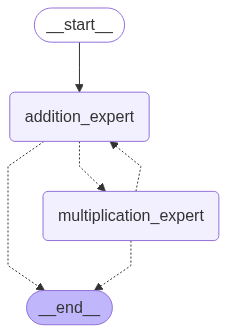

In [34]:
graph=StateGraph(MessagesState)

graph.add_node("addition_expert",addition_expert)
graph.add_node("multiplication_expert",multiplication_expert)

graph.add_edge(START,"addition_expert")

graph.compile()